In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
seed = sum([3, 15, 13, 16, 1, 19])
np.random.seed(seed)
num_samples = 7214
num_folds = 10

[array([5460, 4996, 5661,  885, 1223, 5480, 6101,  825, 2502, 6308, 5200,
       2101, 3140, 5378, 3336, 4486, 5418, 2909, 3251,  229, 2930, 1938,
       1133, 2207, 1413, 1008, 5963,  704, 6970, 1839, 4800, 2658, 3384,
       3571, 1063, 1669, 5759, 5944, 2965, 6953,  291, 1000, 3978, 4367,
       2212, 5911, 5831,  345, 5053,  789, 4797, 3587, 5641, 2394, 6035,
        225, 5761,   87, 1703, 3092, 4674, 3499, 6110, 1674, 3312, 6642,
       3706, 5914, 5043, 4828, 2168,  412, 5979, 3267,  929,  529, 2104,
       3475, 1724, 2732, 6025, 1746, 5548, 7093, 4264, 5220, 1134, 4006,
       2220,  913, 3249, 1097, 3399, 3101, 2563, 5412, 4546, 5131, 4976,
        538,  237, 4025, 2730, 6097, 6218, 1696,  480, 6784, 1663, 4154,
       3520, 4662,  174, 5155, 3157, 1759, 4456, 4335,  129, 6879, 1269,
       5854,  610, 4082, 4928, 3659, 4776,  227, 4757, 4693, 5581, 5400,
       5882, 4611, 6217, 2765, 2120, 7084, 1794, 2688, 5552,   47, 5620,
       5997, 5308, 5441,  733, 3491, 1770, 1865,  

In [161]:
def cnf_mat(preds, true):
    # true down, preds across
    true.name = 'True'
    preds.name = 'Preds'
    cnf = pd.crosstab(true, preds)
    print cnf
    tp = cnf.loc[1, 1]
    fp = cnf.loc[0, 1]
    fn = cnf.loc[1, 0]
    tn = cnf.loc[0, 0]
    print 'TPR: {0}'.format(float(tp) / (tp + fn))
    print 'FPR: {0}'.format(float(fp) / (fp + tn))
    print 'TP: {0}, FP: {1}, FN: {2}, TN: {3}'.format(tp, fp, fn, tn)
    print confusion_matrix(true, preds)
    print classification_report(true, preds)
    return [tp, fp, fn, tn]

def calc_rates(samps, pred_arr, true_arr, compas_arr=None):
    preds = pred_arr.loc[samps.astype(bool)]
    compas = compas_arr.loc[samps.astype(bool)]
    true = true_arr.loc[samps.astype(bool)]
    print 'CORELS'
    corels_cnf = cnf_mat(preds, true)
    print compas.shape, true.shape
    print 'COMPAS'
    compas_cnf = cnf_mat(compas, true)
    print compas_cnf[1]
    return corels_cnf, compas_cnf

In [ ]:
for i range(num_folds):
    print i

In [173]:
def analyze_data(train=True):
    binary = pd.read_csv('../data/compas-binary.csv')
    np.random.seed(seed)
    splits = np.split(np.random.permutation(num_samples / num_folds * num_folds), num_folds)
    compas = pd.read_csv('../compas/compas-scores-two-years.csv')
    compas_scores = compas['decile_score']
    compas_preds = (compas_scores > 4).astype(int)
    labels = ['Black CORELS', 'Black COMPAS', 'White CORELS', 'White COMPAS']
    white_corels, white_compas, black_corels, black_compas = [], [], [], []
    train_or_test = 'train' if train else 'test'
    for i in range(num_folds):
        print i
        fname = '../logs/for-compas_{0}_train.out-curious_lb-with_prefix_perm_map-minor-removed=none-max_num_nodes=100000000-c=0.0050000-v=100-f=1000-opt.txt'.format(i)
        with open(fname, 'r') as f:
            line = f.readline()
            opt = map(lambda x: x.split('~'), line.split(';'))
            print opt
        
        if train:
            split_i = np.concatenate([splits[j] for j in range(num_folds) if (j != i)])
        else:
            split_i = splits[i]
        print split_i
        bin_i = binary.loc[split_i].reset_index(drop=True).T
        compas_i = compas_preds.loc[split_i].reset_index(drop=True)
        black = bin_i.loc['Race=African-American:True']
        white = bin_i.loc['Race=Caucasian:True']

        nrules = 0
        with open('../data/CrossValidation/compas_{0}_{1}.out'.format(i, train_or_test)) as f:
            line = f.readline()
            nrules = len(line.split()) - 1
        out = pd.read_csv('../data/CrossValidation/compas_{0}_{1}.out'.format(i, train_or_test), sep=' ', names=['Rule'] + range(nrules))
        label = pd.read_csv('../data/CrossValidation/compas_{0}_{1}.label'.format(i, train_or_test), sep=' ', names=['Rule'] + range(nrules))
        out.set_index('Rule', inplace=True)
        label.set_index('Rule', inplace=True)

        captured = set()
        preds = []
        for (rule, pred) in opt[:-1]:
            cappd = out.ix[rule] == 1
            unfiltered_cappd = out.T[cappd].index
            filtered_cappd = set(unfiltered_cappd).difference(captured)
            preds += map(lambda x: (x, pred), filtered_cappd)
            captured = captured.union(filtered_cappd)

        # Handle default rule
        _, def_pred = opt[-1]
        preds += [(x, def_pred) for x in set(range(nrules)).difference(captured)]
        sorted_preds = sorted(preds, key=lambda x: x[0])
        pred_arr = pd.Series(map(lambda x: int(x[1]), sorted_preds))
        true_arr = label.iloc[1, :]

        print 'BLACK'
        black_corels_cnf, black_compas_cnf = calc_rates(black, pred_arr, true_arr, compas_arr=compas_i)
        print 'WHITE'
        white_corels_cnf, white_compas_cnf = calc_rates(white, pred_arr, true_arr, compas_arr=compas_i)

        black_corels.append(black_corels_cnf)
        black_compas.append(black_compas_cnf)
        white_corels.append(white_corels_cnf)
        white_compas.append(white_compas_cnf)
    algs = zip(labels, [black_corels, black_compas, white_corels, white_compas])
    return algs

In [182]:
algs = analyze_data(train=True)

0
[['{age:23-25,priors:2-3}', '1'], ['{sex:Male,age:21-22}', '1'], ['{age:18-20}', '1'], ['{priors:>3}', '1'], ['default', '0']]
[2304 4798  900 ..., 1738 4917 2883]
BLACK
CORELS
Preds     0     1
True             
0      1007   616
1       494  1208
TPR: 0.709753231492
FPR: 0.379544054221
TP: 1208, FP: 616, FN: 494, TN: 1007
[[1007  616]
 [ 494 1208]]
             precision    recall  f1-score   support

          0       0.67      0.62      0.64      1623
          1       0.66      0.71      0.69      1702

avg / total       0.67      0.67      0.67      3325

(3325,) (3325,)
COMPAS
Preds    0     1
True            
0      899   724
1      481  1221
TPR: 0.717391304348
FPR: 0.446087492298
TP: 1221, FP: 724, FN: 481, TN: 899
[[ 899  724]
 [ 481 1221]]
             precision    recall  f1-score   support

          0       0.65      0.55      0.60      1623
          1       0.63      0.72      0.67      1702

avg / total       0.64      0.64      0.64      3325

724
WHITE
CORELS
Pred

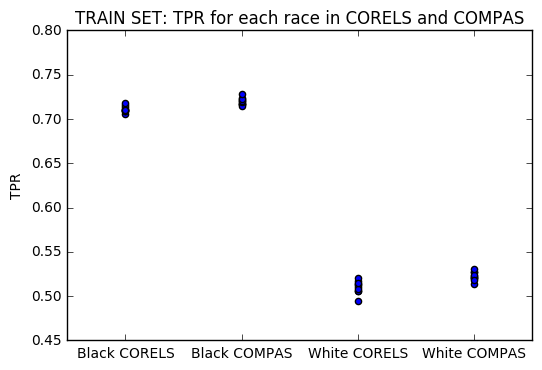

In [183]:
def tpr(l):
    return map(lambda x: float(x[0]) / (x[0] + x[2]), l)
x = [[i] * num_folds for i in range(len(algs))]
y = [tpr(a[1]) for a in algs]
plt.scatter(x, y)
plt.xticks(range(len(algs)), labels)
plt.ylabel('TPR')
plt.title('TRAIN SET: TPR for each race in CORELS and COMPAS')
plt.show()

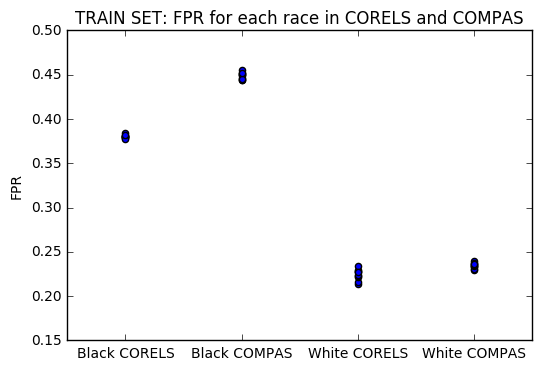

In [184]:
def fpr(l):
    return map(lambda x: float(x[1]) / (x[1] + x[3]), l)
x_fp = [[i] * num_folds for i in range(len(algs))]
y_fp = [fpr(a[1]) for a in algs]
plt.scatter(x_fp, y_fp)
plt.xticks(range(len(algs)), labels)
plt.ylabel('FPR')
plt.title('TRAIN SET: FPR for each race in CORELS and COMPAS')
plt.show()

In [179]:
def stats(l):
    print 'TP, FP, FN, TN'
    print 'Means:', np.mean(l, axis=0)
    print 'Std deviations:', np.std(l, axis=0)
for a in algs:
    print a[0]
    stats(a[1])

Black CORELS
TP, FP, FN, TN
Means: [ 135.2   68.2   54.9  111.1]
Std deviations: [ 7.67854153  3.76297754  8.79147314  6.81835757]
Black COMPAS
TP, FP, FN, TN
Means: [ 136.9   80.5   53.2   98.8]
Std deviations: [ 10.61555463   7.83900504   8.36420947   6.89637586]
White CORELS
TP, FP, FN, TN
Means: [  49.3   33.4   47.3  115.4]
Std deviations: [  7.4303432    7.87654747   8.25893456  10.04191217]
White COMPAS
TP, FP, FN, TN
Means: [  50.5   34.9   46.1  113.9]
Std deviations: [ 4.41021541  4.15812458  7.81600921  6.36317531]


In [ ]:
# tp, fp, fn, tn
# FPR: float(fp) / (fp + tn)
# TPR: float(tp) / (tp + fn)

In [ ]:
white.sum() + black.sum()

In [ ]:
white.sum()

In [ ]:
pred_arr.sum()

In [ ]:
compas_preds.sum()